In [726]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Concatenate, Reshape, AveragePooling2D
from keras.layers import Input, Bidirectional, GlobalMaxPool1D, LSTM
from keras.applications.densenet import DenseNet121, preprocess_input
from keras import Input
from keras.initializers import he_normal
from keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import RobertaTokenizer, TFRobertaModel, RobertaConfig
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk
from PIL import Image
from tensorflow.keras.optimizers import Adam, RMSprop
from shutil import rmtree, copyfile
from itertools import cycle
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, average_precision_score, f1_score
import seaborn as sb
import tensorflow as tf
import matplotlib.cm as cm
import re
from tensorflow.keras.utils import Sequence
from matplotlib.lines import Line2D

# Project variables

In [632]:
m_name = "combo model v3_channel_iter"
p_dir = os.path.join("../combo models", m_name)

In [633]:
def create_dir(dir_path: str):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

In [634]:
def clear_dir(dir_path: str):
    for item in os.listdir(dir_path):
        fp = os.path.join(dir_path, item)
        if os.path.isfile(fp):
            os.remove(fp)
        if os.path.isdir(fp):
            rmtree(fp)

In [635]:
create_dir(p_dir)
clear_dir(p_dir)

# Read and transform scraped dataframes

In [636]:
fp = "../scraped data"

channels = pd.read_pickle(os.path.join(fp, "channels.pkl"))
videos = pd.read_pickle(os.path.join(fp, "videos.pkl"))

In [637]:
def transform_channels(df: pd.DataFrame) -> pd.DataFrame:
    # Date string into proper date
    df.published = pd.to_datetime(df.published)
    
    # Convert field type into int64
    fields = ["video_count", "view_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("int64")
    
    # Convert field type into float64
    fields = ["subscriber_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("float64")
    
    # Add of channel in months
    df["age_mth"] = (pd.to_datetime("today", utc=True).year - df.published.dt.year) * 12 \
        + (pd.to_datetime("today", utc=True).month - df.published.dt.month)
        
    # Drop unnecessary fields
    df.drop(columns=["custom_url", "country"] + [c for c in df.columns if c.startswith("thumbnail")], inplace=True)
    
    # Remove channels without subscriber_count
    df = df.loc[df.subscriber_count.notnull(), :]
    
    # Remove Simplilearn
    df = df.loc[df["title"] != "Simplilearn", :]
    
    return df

In [638]:
def transform_videos(df: pd.DataFrame) -> pd.DataFrame:    
    # Date string into proper date
    df.published = pd.to_datetime(df.published)
    
    # Convert field type to bool
    fields = ["broadcast"]
    df.loc[:, fields] = df.loc[:, fields].astype("bool")
    
    # Convert field type into int64
    fields = ["category_id"]
    df.loc[:, fields] = df.loc[:, fields].astype("int64")
    
    # Convert field type into float64
    fields = ["comment_count", "dislike_count", "like_count", "view_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("float64")
    
    df["published_mth"] = (pd.to_datetime("today", utc=True).year - df.published.dt.year) * 12 \
        + (pd.to_datetime("today", utc=True).month - df.published.dt.month)
    df["title_len"] = df.title.str.len()
    
    df.drop(columns=["favorite_count", "broadcast", "audio_language", "comment_count", "category_id"] \
            + [c for c in df.columns if c.startswith("thumbnail")], inplace=True)
    
    df = df.loc[df.like_count.notnull() & df.dislike_count.notnull() & df.view_count.notnull(), :]
    
    return df

In [639]:
channels_trans = transform_channels(channels)
videos_trans = transform_videos(videos)
combo = videos_trans.merge(channels_trans[["id", "view_count","published", "age_mth", "subscriber_count",
                                             "video_count"]], 
                           how="inner", left_on="channel_id", right_on="id", suffixes=["_video", "_channel"])
combo["ln_vc_norm"] = np.log(combo.view_count_video / combo.subscriber_count)
combo.shape

(16300, 17)

# Define categories

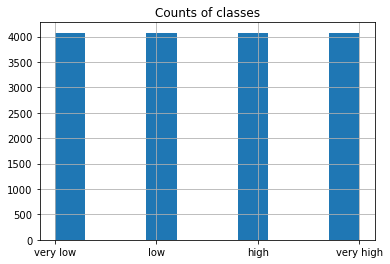

In [640]:
cat_lbl = ["very low", "low", "high", "very high"]
combo.loc[:, "qtl"] = pd.qcut(combo.ln_vc_norm, len(cat_lbl), labels=cat_lbl, precision=6)
combo.sort_values(by=["qtl"]).qtl.hist()
plt.title("Counts of classes")
plt.show()

In [641]:
excl = [
    ['The Planetary Society', 'CGP Grey', 'The Action Lab', 'PBS Space Time', 'SciShow', 'D!NG', 'MinuteEarth', 'Fermilab'],
    ['Up and Atom', 'StarTalk', 'Vsauce2', 'Periodic Videos', 'OverSimplified', '3Blue1Brown', 'Primer' "It's Okay To Be Smart"],
    ['SmarterEveryDay', 'Massachusetts Institute of Technology (MIT)', 'Kurzgesagt – In a Nutshell', 'Vsauce2', 'DoS - Domain of Science', 'Sixty Symbols', 'ScienceClic English', 'TED-Ed'],
    ['minutephysics', 'D!NG', 'Veritasium', 'Quanta Magazine', 'Kurzgesagt – In a Nutshell', 'PBS Space Time', 'Real Engineering', 'Physics Videos by Eugene Khutoryansky'],
    ['BrainCraft', 'Numberphile', 'ScienceClic English', 'DoS - Domain of Science', 'Science ABC', 'Vsauce', 'Veritasium', 'CrashCourse'],
    ['The Science Asylum', 'Massachusetts Institute of Technology (MIT)', 'SciShow', 'Kurzgesagt – In a Nutshell', 'No Dumb Questions', 'Science ABC', 'Veritasium', 'StarTalk'],
    ['CrashCourse', 'Primer', 'The Science Asylum' "It's Okay To Be Smart" 'AsapSCIENCE', 'The Royal Institution', 'The Action Lab', 'Numberphile'],
    ['The Planetary Society', 'Periodic Videos', 'Science ABC', 'SciShow', 'SmarterEveryDay', 'Veritasium', 'Real Engineering', 'TED-Ed']       
]

In [642]:
# excl_channels = np.random.choice(combo["channel_name"].unique(), 8, replace=False)
version = 7
excl_channels = excl[version]
combo_excl = combo.loc[combo["channel_name"].isin(excl_channels), :]
combo = combo.loc[~combo["channel_name"].isin(excl_channels), :]
combo.shape

(9819, 18)

In [643]:
combo_excl.shape

(6481, 18)

In [644]:
print(excl_channels)

['The Planetary Society', 'Periodic Videos', 'Science ABC', 'SciShow', 'SmarterEveryDay', 'Veritasium', 'Real Engineering', 'TED-Ed']


# Split dataset (use only top and bottom quartile data)

In [645]:
cat_lbl = ["very low", "very high"]
combo2 = combo.loc[~combo.qtl.isin(cat_lbl)] 
combo = combo.loc[combo.qtl.isin(cat_lbl)]
combo.qtl = combo.qtl.cat.remove_unused_categories()

y = combo.qtl
x = combo.loc[:, [c for c in combo.columns if c != "qtl"]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=4711)

x_train.to_pickle(os.path.join(p_dir, "x_train.pkl"))
y_train.to_pickle(os.path.join(p_dir, "y_train.pkl"))
x_val.to_pickle(os.path.join(p_dir,"x_val.pkl"))
y_val.to_pickle(os.path.join(p_dir, "y_val.pkl"))
x_test.to_pickle(os.path.join(p_dir,"x_test.pkl"))
y_test.to_pickle(os.path.join(p_dir, "y_test.pkl"))

print(x_train.shape[0], x_val.shape[0], x_test.shape[0])

3207 1069 1070


In [646]:
combo.shape

(5346, 18)

In [647]:
combo2.shape

(4473, 18)

# Build the model

In [648]:
def create_img_model():
    
    inp = Input(shape=(180, 320, 3))
    
    base_model = DenseNet121(weights="imagenet", include_top=False, input_tensor=inp)
    base_model.trainable = False
    x = base_model.output
    
    x = AveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation="relu")(x)
    x = Dense(256, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    out = Dense(len(cat_lbl), activation="sigmoid")(x)
    
    model = Model(base_model.input, out)
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=0.0005), 
                  metrics=["accuracy"])
    
    return model

In [649]:
pt_model = "roberta-base"

In [650]:
def create_nlp_model():
    
    # config = RobertaConfig(dropout=0.2, attention_dropout=0.2)
    # config.output_hidden_states=False
    transformer_model = TFRobertaModel.from_pretrained(pt_model)

    in_ids = Input(shape=(100,), name="input_token", dtype="int32")
    in_masks = Input(shape=(100,), name="masked_token", dtype="int32")

    emb = transformer_model(in_ids, attention_mask=in_masks)[0]
    x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0))(emb)
    x = GlobalMaxPool1D()(x)
    x = Flatten()(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(2, activation="softmax")(x)
    model = Model(inputs=[in_ids, in_masks], outputs=x)
        
    return model

In [651]:
def create_model():
    
    # Load image model with weights and remove last layer
    m_name = "densenet_2_classes_bce_fmt2_channel"
    img_model = create_img_model()
    img_model.load_weights("../img models/{a}/{a}".format(a=m_name))
    for layer in img_model.layers:
        layer.trainable = False
    
    # Load nlp model with weights and remove last layer
    m_name = "roberta_2_classes_channel"
    nlp_model = create_nlp_model()
    nlp_model.load_weights("../nlp models/{a}/{a}".format(a=m_name))
    for layer in nlp_model.layers:
        layer.trainable = False
    
    m1 = img_model.layers[-4].output
    m1 = Dense(50, activation="relu")(m1)
    m1 = BatchNormalization()(m1)
    m2 = nlp_model.layers[-3].output
    # m2 = BatchNormalization()(m2)
    x = Concatenate()([m1, m2])
    # x = BatchNormalization()(x)
    # x = Dropout(0.3)(x)
    # x = Dense(100, activation="relu")(x)
    # x = Dropout(0.5)(x)
    x = Dense(20, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(2, activation="softmax")(x)
    model = Model(inputs=[img_model.input, nlp_model.input[0], nlp_model.input[1]], outputs=x)
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.0005),
                  metrics=["accuracy"])
    
    return model    

In [652]:
model = create_model()

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [653]:
# model.summary()

# Text preprocessing and tokenization

In [654]:
def preprocessing_sentence(txt: str, remove_stopwords: bool=False) -> str:
    field = "title"
    stw = set(stopwords.words("english"))
    
    def cleanse_row(txt, field, stw, stopwords=False):
        # Remove HTML from text
        soup = BeautifulSoup(txt)
        txt = soup.get_text()
        
        # Remove stopwords
        if stopwords:
            txt = " ".join([w for w in txt.split() if w not in stw])
        
        return txt
    
    txt = cleanse_row(txt, field, stw, remove_stopwords)
    return txt

In [655]:
# Download the stopwork corpus
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [656]:
remove_stopwords = False

def preprocess_sentences(x: pd.DataFrame, remove_stopwords: bool=False) -> list():
    x_pp = preprocessing_sentence(x, remove_stopwords)
    x_pp = x_pp.tolist()
    return x_pp

In [657]:
tok = RobertaTokenizer.from_pretrained(pt_model, do_lower=True, add_special_tokens=True, max_length=100, pad_to_max_length=True)

In [658]:
def tokenize(sentence, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    
    inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=100, padding="max_length", return_attention_mask=True, 
                                   return_token_type_ids=True, truncation=True)
    input_ids.append(inputs["input_ids"])
    input_masks.append(inputs["attention_mask"])
    input_segments.append(inputs["token_type_ids"])
        
    return np.asarray(input_ids, dtype="int32"), np.asarray(input_masks, dtype="int32"), np.asarray(input_segments, dtype="int32")

# Prepare DataGenerators

In [659]:
class TkDataGenerator(Sequence):
    def __init__(self, df, img_col, txt_col, y_col, img_dir, img_pp_func, txt_pp_func, tok_func, tokenizer, lb, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.img_pp_func = img_pp_func
        self.txt_pp_func = txt_pp_func
        self.tok_func = tok_func
        self.tokenizer = tokenizer
        self.lb = lb
        self.img_col = img_col
        self.txt_col = txt_col
        self.y_col = y_col
        self.lb = lb
        self.img_dir = img_dir
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        
        x1, x2, x3, y = self.__get_data(batch)
        return (x1, x2, x3), y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def __get_data(self, batch):
        x1 = np.empty((self.batch_size, *(180, 320, 3)), dtype="float32")
        x2 = np.empty((self.batch_size, 100), dtype="int32")
        x3 = np.empty((self.batch_size, 100), dtype="int32")
        y = np.empty((self.batch_size, 2), dtype="float32")
        
        for i, i_df in enumerate(batch):
            img = load_img(os.path.join(img_dir, "{}.jpg".format(self.df.loc[i_df, self.img_col])), target_size=(180, 320))
            img = self.img_pp_func(np.array(img)).astype("float32")
            pp = self.txt_pp_func(self.df.loc[i_df, self.txt_col])
            t1, t2, t3 = self.tok_func(pp, self.tokenizer)
            
            x1[i] = img
            x2[i] = t1
            x3[i] = t2
            y[i] = np.array([int(l == self.df.loc[i_df, self.y_col]) for l in self.lb])
            
        return x1, x2, x3, y

In [660]:
def train_generator(X, y, img_dir, lb, batch_size):
    combo = pd.concat([X, y], axis="columns")
    combo["file_name"] = combo.id_video + ".jpg"
    datagen = TkDataGenerator(df=combo, 
                              img_col="id_video", 
                              txt_col="title",
                              y_col="qtl",
                              img_dir=img_dir, 
                              img_pp_func=preprocess_input, 
                              txt_pp_func=preprocessing_sentence, 
                              tok_func=tokenize,
                              tokenizer=tok, 
                              lb=lb,
                              batch_size=batch_size, 
                              shuffle=True)
    return datagen

def val_generator(X, y, img_dir, lb, batch_size):
    combo = pd.concat([X, y], axis="columns")
    combo["file_name"] = combo.id_video + ".jpg"
    datagen = TkDataGenerator(df=combo, 
                              img_col="id_video", 
                              txt_col="title",
                              y_col="qtl",
                              img_dir=img_dir, 
                              img_pp_func=preprocess_input, 
                              txt_pp_func=preprocessing_sentence, 
                              tok_func=tokenize,
                              tokenizer=tok, 
                              lb=lb,
                              batch_size=batch_size, 
                              shuffle=True)
    return datagen

def test_generator(X, y, img_dir, lb):
    combo = pd.concat([X, y], axis="columns")
    combo["file_name"] = combo.id_video + ".jpg"
    datagen = TkDataGenerator(df=combo, 
                              img_col="id_video", 
                              txt_col="title",
                              y_col="qtl",
                              img_dir=img_dir, 
                              img_pp_func=preprocess_input, 
                              txt_pp_func=preprocessing_sentence, 
                              tok_func=tokenize,
                              tokenizer=tok, 
                              lb=lb,
                              batch_size=1, 
                              shuffle=False)
    return datagen

# Train the model

In [661]:
img_dir = "../images_medium"
batch_size = 32

train_gen = train_generator(x_train, y_train, img_dir, cat_lbl, batch_size)
val_gen = val_generator(x_val, y_val, img_dir, cat_lbl, batch_size)

metric = "val_loss"

es = EarlyStopping(monitor=metric, 
                   mode="min", 
                   patience=5, 
                   restore_best_weights=True)

checkpoint = ModelCheckpoint(os.path.join(p_dir, "{}".format(m_name)), 
                             monitor=metric, 
                             verbose=2, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min')

hist = model.fit(train_gen,
                 epochs=200,
                 validation_data=val_gen,
                 verbose=1,
                 callbacks=[checkpoint, es])

Epoch 1/200
100/100 [==============================] - 61s 458ms/step - loss: 0.4144 - accuracy: 0.8134 - val_loss: 0.2543 - val_accuracy: 0.9053

Epoch 00001: val_loss improved from inf to 0.25429, saving model to ../combo models/combo model v3_channel_iter/combo model v3_channel_iter
Epoch 2/200
100/100 [==============================] - 43s 426ms/step - loss: 0.2897 - accuracy: 0.8809 - val_loss: 0.2355 - val_accuracy: 0.9148

Epoch 00002: val_loss improved from 0.25429 to 0.23551, saving model to ../combo models/combo model v3_channel_iter/combo model v3_channel_iter
Epoch 3/200
100/100 [==============================] - 43s 432ms/step - loss: 0.2750 - accuracy: 0.8831 - val_loss: 0.2262 - val_accuracy: 0.9157

Epoch 00003: val_loss improved from 0.23551 to 0.22623, saving model to ../combo models/combo model v3_channel_iter/combo model v3_channel_iter
Epoch 4/200
100/100 [==============================] - 44s 437ms/step - loss: 0.2685 - accuracy: 0.8878 - val_loss: 0.2308 - val_ac

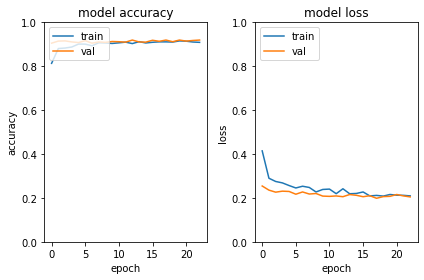

In [662]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(hist.history["accuracy"])
axs[0].plot(hist.history["val_accuracy"])
axs[0].set_title("model accuracy")
axs[0].set_ylabel("accuracy")
axs[0].set_xlabel("epoch")
axs[0].set_ylim(0, 1)
axs[0].legend(["train", "val"], loc="upper left")

axs[1].plot(hist.history["loss"])
axs[1].plot(hist.history["val_loss"])
axs[1].set_title("model loss")
axs[1].set_ylabel("loss")
axs[1].set_xlabel("epoch")
axs[1].set_ylim(0, 1)
axs[1].legend(["train", "val"], loc="upper left")

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(p_dir, "accuracy_loss.jpg"))

# Sample images per category

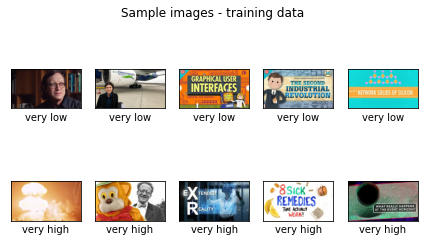

In [663]:
s = combo.loc[combo["id_video"].isin(x_train["id_video"]), ["id_video", "qtl"]].groupby("qtl", as_index=False).apply(lambda x: x.sample(5, random_state=15))

n_images = 5
fig, axs = plt.subplots(len(cat_lbl), n_images)
i = 0

for idx, row in s.iterrows():
    img = Image.open(os.path.join(img_dir, "{}.jpg".format(row["id_video"])))
    axs[i // n_images, i % n_images].imshow(img)
    axs[i // n_images, i % n_images].xaxis.set_ticklabels([])
    axs[i // n_images, i % n_images].xaxis.set_ticks([])
    axs[i // n_images, i % n_images].set_xlabel(row["qtl"])
    axs[i // n_images, i % n_images].yaxis.set_ticklabels([])
    axs[i // n_images, i % n_images].yaxis.set_ticks([])
    i += 1
plt.tight_layout()
plt.suptitle("Sample images - training data")
plt.show()
fig.savefig(os.path.join(p_dir, "sample_images.jpg"))

# Confusion matrix

In [664]:
# model = load_model(os.path.join(p_dir, "{}".format(m_name)))
model.load_weights(os.path.join(p_dir, "{}".format(m_name)))

## Training dataset (in_sample)

In [665]:
img_dir = "../images_medium"

x_train = pd.read_pickle(os.path.join(p_dir, "x_train.pkl"))
y_train = pd.read_pickle(os.path.join(p_dir, "y_train.pkl"))
train_gen = test_generator(x_train, y_train, img_dir, cat_lbl)
y_train_prob = model.predict(train_gen, steps=y_train.shape[0])
y_pred = np.argmax(y_train_prob, axis=1)
y_pred = pd.Series([cat_lbl[i] for i in y_pred]).astype("category").cat.reorder_categories(cat_lbl)

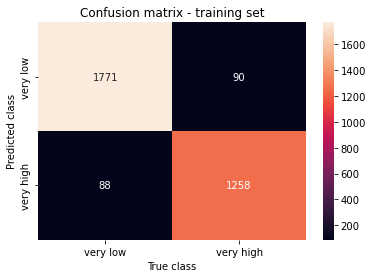

Accuracy: 0.94
Micro precision: 0.94
Micro recall: 0.94
Micro F1-score: 0.94
Macro precision: 0.94
Macro recall: 0.94
Macro F1-score: 0.94
Weighted precision: 0.94
Weighted recall: 0.94
Weighted F1-score: 0.94
              precision    recall  f1-score   support

    very low       0.95      0.95      0.95      1861
   very high       0.93      0.93      0.93      1346

    accuracy                           0.94      3207
   macro avg       0.94      0.94      0.94      3207
weighted avg       0.94      0.94      0.94      3207



In [666]:
cmtx = confusion_matrix(y_train, y_pred)
sb.heatmap(cmtx, annot=True, fmt="d", xticklabels=y_val.cat.categories, yticklabels=y_pred.cat.categories)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion matrix - training set")
plt.savefig(os.path.join(p_dir, "confusion_matrix_train.jpg"))
plt.show()

print("Accuracy: {:0.2f}".format(accuracy_score(y_train, y_pred)))

print("Micro precision: {:0.2f}".format(precision_score(y_train, y_pred, average="micro")))
print("Micro recall: {:0.2f}".format(recall_score(y_train, y_pred, average="micro")))
print("Micro F1-score: {:0.2f}".format(f1_score(y_train, y_pred, average="micro")))

print("Macro precision: {:0.2f}".format(precision_score(y_train, y_pred, average="macro")))
print("Macro recall: {:0.2f}".format(recall_score(y_train, y_pred, average="macro")))
print("Macro F1-score: {:0.2f}".format(f1_score(y_train, y_pred, average="macro")))

print("Weighted precision: {:0.2f}".format(precision_score(y_train, y_pred, average="weighted")))
print("Weighted recall: {:0.2f}".format(recall_score(y_train, y_pred, average="weighted")))
print("Weighted F1-score: {:0.2f}".format(f1_score(y_train, y_pred, average="weighted")))

print(classification_report(y_train, y_pred, target_names=cat_lbl))

## Test dataset (out-of_sample)

In [667]:
img_dir = "../images_medium"

x_test = pd.read_pickle(os.path.join(p_dir, "x_test.pkl"))
y_test = pd.read_pickle(os.path.join(p_dir, "y_test.pkl"))
test_gen = test_generator(x_test, y_test, img_dir, cat_lbl)
y_pred_prob = model.predict(test_gen, steps=y_test.shape[0])
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred = pd.Series([cat_lbl[i] for i in y_pred]).astype("category").cat.reorder_categories(cat_lbl)

In [668]:
print("F1 score: {:0.2f}".format(f1_score(y_test, y_pred, pos_label="very high")))

F1 score: 0.94


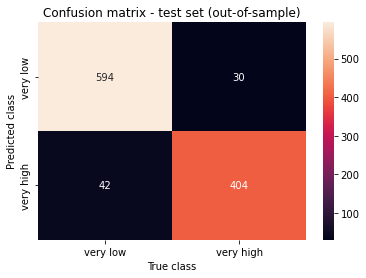

Accuracy: 0.93
Micro precision: 0.93
Micro recall: 0.93
Micro F1-score: 0.93
Macro precision: 0.93
Macro recall: 0.93
Macro F1-score: 0.93
Weighted precision: 0.93
Weighted recall: 0.93
Weighted F1-score: 0.93
              precision    recall  f1-score   support

    very low       0.93      0.95      0.94       624
   very high       0.93      0.91      0.92       446

    accuracy                           0.93      1070
   macro avg       0.93      0.93      0.93      1070
weighted avg       0.93      0.93      0.93      1070



In [669]:
cmtx = confusion_matrix(y_test, y_pred)
sb.heatmap(cmtx, annot=True, fmt="d", xticklabels=y_test.cat.categories, yticklabels=y_pred.cat.categories)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion matrix - test set (out-of-sample)")
plt.savefig(os.path.join(p_dir, "confusion_matrix.jpg"))
plt.show()

print("Accuracy: {:0.2f}".format(accuracy_score(y_test, y_pred)))

print("Micro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="micro")))
print("Micro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="micro")))
print("Micro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="micro")))

print("Macro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="macro")))
print("Macro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="macro")))
print("Macro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="macro")))

print("Weighted precision: {:0.2f}".format(precision_score(y_test, y_pred, average="weighted")))
print("Weighted recall: {:0.2f}".format(recall_score(y_test, y_pred, average="weighted")))
print("Weighted F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="weighted")))

print(classification_report(y_test, y_pred, target_names=cat_lbl))

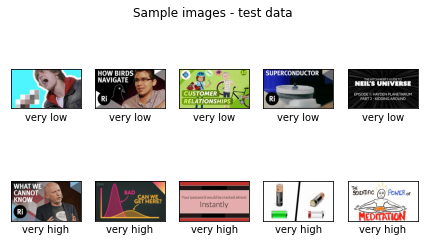

In [670]:
s = combo.loc[combo["id_video"].isin(x_val["id_video"]), ["id_video", "qtl"]].groupby("qtl", as_index=False).apply(lambda x: x.sample(5, random_state=118))

n_images = 5
fig, axs = plt.subplots(len(cat_lbl), n_images)
i = 0

for idx, row in s.iterrows():
    img = Image.open(os.path.join(img_dir, "{}.jpg".format(row["id_video"])))
    axs[i // n_images, i % n_images].imshow(img)
    axs[i // n_images, i % n_images].xaxis.set_ticklabels([])
    axs[i // n_images, i % n_images].xaxis.set_ticks([])
    axs[i // n_images, i % n_images].set_xlabel(row["qtl"])
    axs[i // n_images, i % n_images].yaxis.set_ticklabels([])
    axs[i // n_images, i % n_images].yaxis.set_ticks([])
    i += 1
plt.tight_layout()
plt.suptitle("Sample images - test data")
plt.show()
fig.savefig(os.path.join(p_dir, "sample_images_val.jpg"))

# ROC Curve

In [671]:
class mybinarizer:
    
    def transform(self, s: pd.Series, cats: list) -> np.ndarray:
        d = list()
        for i, v in enumerate(s):
            d.append([l == v for l in cats])
        return np.array(d, dtype="int32")
    
    def reverse_transform(self, arr: np.ndarray) -> pd.Series:
        d = list()
        for i, v in enumerate(arr):
            ct = 0
            for j in v:
                if j == 1:
                    d.append(cat_lbl[ct])
                    continue
                ct += 1
        return pd.Series(d, name="qtl")

## Training dataset (in sample)

In [672]:
lb = mybinarizer()
y_train_no = lb.transform(y_train, cat_lbl)[:, 1]
y_pred_no = y_train_prob[:, 1]
fpr, tpr, thr = roc_curve(y_train_no, y_pred_no)

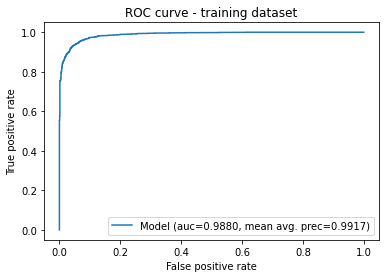

In [673]:
auc_model = auc(fpr, tpr)
mavgp = average_precision_score(y_train_no, y_pred_no)

# plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label="Model (auc={:0.4f}, mean avg. prec={:0.4f})".format(auc_model, mavgp))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve - training dataset")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve_train.jpg"))
plt.show()

## Test dataset (out-of-sample)

In [674]:
lb = mybinarizer()
y_test_no = lb.transform(y_test, cat_lbl)[:, 1]
y_pred_no = y_pred_prob[:,  1]
fpr, tpr, thr = roc_curve(y_test_no, y_pred_no)

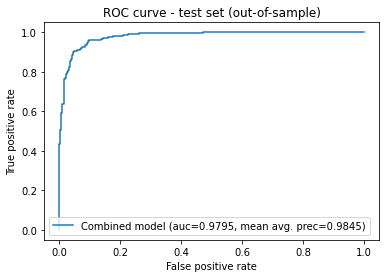

In [675]:
auc_model = auc(fpr, tpr)
mavgp = average_precision_score(y_test_no, y_pred_no)

# plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label="Combined model (auc={:0.4f}, mean avg. prec={:0.4f})".format(auc_model, mavgp))
df_roc = pd.DataFrame({"fpr": fpr, "tpr": tpr})
df_roc.to_pickle("../roc_combo_is_v{}.pkl".format(version))
d_roc = pd.DataFrame({"auc": [auc_model], "mavgp": [mavgp]})
d_roc.to_pickle("../d_combo_is_v{}.pkl".format(version))

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve - test set (out-of-sample)")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve.jpg"))
plt.show()

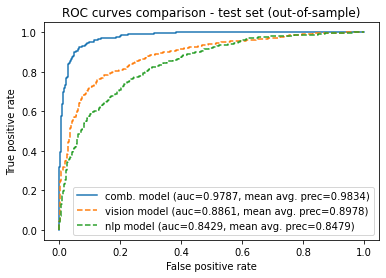

In [676]:
df_combo = pd.read_pickle("../roc_combo.pkl")
d_combo = pd.read_pickle("../d_combo.pkl")
plt.plot(df_combo["fpr"], df_combo["tpr"], label="comb. model (auc={:0.4f}, mean avg. prec={:0.4f})".format(d_combo["auc"][0], d_combo["mavgp"][0]))
df_img = pd.read_pickle("../roc_img.pkl")
d_img = pd.read_pickle("../d_img.pkl")
plt.plot(df_img["fpr"], df_img["tpr"], label="vision model (auc={:0.4f}, mean avg. prec={:0.4f})".format(d_img["auc"][0], d_img["mavgp"][0]), linestyle="dashed")
df_nlp = pd.read_pickle("../roc_nlp.pkl")
d_nlp = pd.read_pickle("../d_nlp.pkl")
plt.plot(df_nlp["fpr"], df_nlp["tpr"], label="nlp model (auc={:0.4f}, mean avg. prec={:0.4f})".format(d_nlp["auc"][0], d_nlp["mavgp"][0]), linestyle="dashed")

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curves comparison - test set (out-of-sample)")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve_all.jpg"))
plt.show()

# Class probability histograms

## Without middle classes

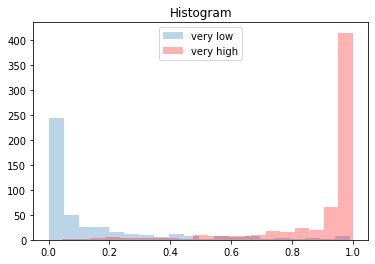

In [677]:
m0 = y_test_no == 0
c0 = y_pred_prob[m0, 1]
m1 = y_test_no == 1
c1 = y_pred_prob[m1, 1]

plt.hist(c0, alpha=0.3, bins=20)
plt.hist(c1, color="red", alpha=0.3, bins=20)
plt.title("Histogram")
plt.legend(cat_lbl, loc="upper center")
plt.savefig(os.path.join(p_dir, "histogram.jpg"))
plt.show()

## Including middle classes

In [678]:
# cat_lbl2 = ["very low", "low", "high", "very high"]
# combo2 = combo.copy()
# combo2.loc[:, "qtl"] = pd.qcut(combo.ln_vc_norm, len(cat_lbl2), labels=cat_lbl2, precision=6)

In [679]:
# combo2 = combo2.loc[combo2.qtl.isin(["low", "high"]), :]
# combo2.qtl = combo2.qtl.cat.remove_unused_categories()

y2 = combo2.qtl
x2 = combo2.loc[:, [c for c in combo2.columns if c != "qtl"]]

x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2, random_state=42)
x_train2, x_val2, y_train2, y_val2 = train_test_split(x_train2, y_train2, test_size=0.25, random_state=4711)

print(x_train2.shape[0], x_val2.shape[0], x_test2.shape[0])

2683 895 895


In [680]:
test_gen2 = test_generator(x_test2, y_test2, img_dir, cat_lbl)
y_pred_prob2 = model.predict(test_gen2, steps=y_test2.shape[0])
y_pred2 = np.argmax(y_pred_prob2, axis=1)
y_pred2 = pd.Series([cat_lbl[i] for i in y_pred2]).astype("category").cat.reorder_categories(cat_lbl)

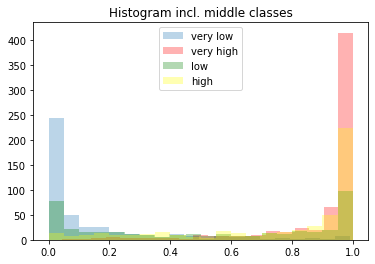

In [681]:
m0 = y_test_no == 0
c0 = y_pred_prob[m0, 1]
m1 = y_test_no == 1
c1 = y_pred_prob[m1, 1]

m3 = y_test2 == "low"
c2 = y_pred_prob2[m3, 1]

m4 = y_test2 == "high"
c3 = y_pred_prob2[m4, 1]

plt.hist(c0, alpha=0.3, label="", bins=20)
plt.hist(c1, color="red", alpha=0.3, label="", bins=20)
plt.hist(c2, color="green", alpha=0.3, label="", bins=20)
plt.hist(c3, color="yellow", alpha=0.3, label="", bins=20)
plt.title("Histogram incl. middle classes")
plt.legend(cat_lbl + ["low", "high"], loc="upper center")
plt.savefig(os.path.join(p_dir, "histogram_w_medium.jpg"))
plt.show()

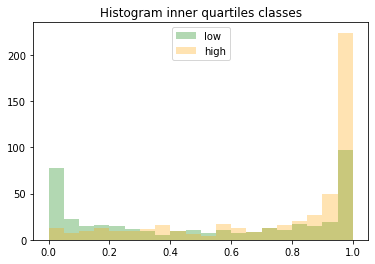

In [682]:
m3 = y_test2 == "low"
c2 = y_pred_prob2[m3, 1]

m4 = y_test2 == "high"
c3 = y_pred_prob2[m4, 1]

plt.hist(c2, color="green", alpha=0.3, label="", bins=20)
plt.hist(c3, color="orange", alpha=0.3, label="", bins=20)
plt.title("Histogram inner quartiles classes")
plt.legend(["low", "high"], loc="upper center")
plt.savefig(os.path.join(p_dir, "histogram_medium.jpg"))
plt.show()

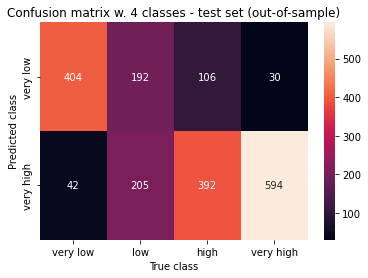

In [683]:
vhvl = pd.concat([y_pred.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1, ignore_index=True)
vhvl.columns = ["pred", "truth"]

hl = pd.concat([y_pred2.reset_index(drop=True), y_test2.reset_index(drop=True)], axis=1, ignore_index=True)
hl.columns = ["pred", "truth"]

tot = pd.concat([vhvl, hl], axis=0)
tot = tot.groupby(["pred", "truth"]).agg({"pred": "count"})
tot.rename(columns={"pred": "count"}, inplace=True)
tot.reset_index(inplace=True)
tot = tot.pivot(index="pred", columns="truth", values="count")
tot = tot.reindex(["very low", "low", "high", "very high"], axis=1)

sb.heatmap(tot, annot=True, fmt="d")
plt.ylabel("Predicted class")
plt.xlabel("True class")
plt.title("Confusion matrix w. 4 classes - test set (out-of-sample)")
plt.savefig(os.path.join(p_dir, "confusion_matrix_4 classes.jpg"))
plt.show()

# Sample images with titles

In [684]:
combo.loc[combo["channel_name"] == "CGP Grey", :].sort_values("ln_vc_norm", ascending=False).head(15)

,id_video,title,channel_id,channel_name,published_video,like_count,dislike_count,view_count_video,published_mth,title_len,id_channel,view_count_channel,published_channel,age_mth,subscriber_count,video_count,ln_vc_norm,qtl
3249,iHzzSao6ypE,The Simple Solution to Traffic,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2016-08-31 12:36:39+00:00,682773.0,20459.0,26495364.0,64,30,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,1.659564,very high
3338,rNu8XDBSn10,"The Difference between the United Kingdom, Gre...",UC2C_jShtL725hvbm1arSV9w,CGP Grey,2011-01-30 16:19:41+00:00,275190.0,10881.0,19081762.0,131,78,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,1.331327,very high
3291,kF8I_r9XT7A,How to Become Pope,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2013-02-19 13:30:39+00:00,260288.0,4803.0,15337439.0,106,18,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,1.112891,very high
3220,oAHbLRjF0vo,The Better Boarding Method Airlines Won't Use,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2019-02-04 18:31:38+00:00,418999.0,8819.0,14510184.0,34,45,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,1.057445,very high
3248,rStL7niR7gs,The Rules for Rulers,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2016-10-24 15:15:59+00:00,419256.0,7164.0,14508362.0,62,20,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,1.057319,very high
3273,7Pq-S557XQU,Humans Need Not Apply,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2014-08-13 12:00:03+00:00,316083.0,6458.0,14370579.0,88,21,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,1.047777,very high
3259,jNgP6d9HraI,Brief History of the Royal Family,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2015-09-09 07:10:21+00:00,219467.0,4661.0,13522905.0,75,33,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,0.986979,very high
3287,qMkYlIA7mgw,Canada & The United States (Bizarre Borders Pa...,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2013-06-05 21:35:43+00:00,149246.0,2041.0,13320196.0,102,51,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,0.971875,very high
3280,uqH_Y1TupoQ,The Law You Won't Be Told,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2014-02-12 15:12:25+00:00,206997.0,3735.0,12441879.0,94,25,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,0.903662,very high
3275,ASSOQDQvVLU,American Empire,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2014-07-03 14:35:38+00:00,150020.0,3437.0,11118117.0,89,15,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,0.791170,very high


In [685]:
titles = [
    "These are the asteroids to worry about",
    "The Egg - A Short Story",
    "What is the Wave/Particle Duality? Part 1",
    "How High Can We Build?",
    "Why It Sucks to Be a Male Hyena",
    "The Simple Solution to Traffic"
]
s = combo.loc[combo["title"].isin(titles), ["id_video", "title", "channel_name"]].sort_values(["channel_name"])

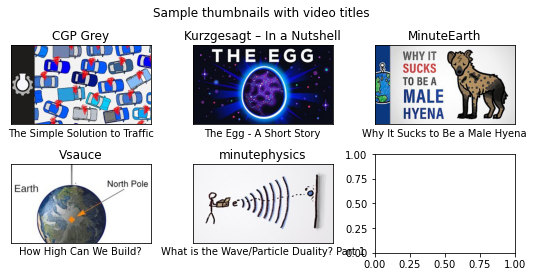

In [686]:
ipr = 3
fig, axs = plt.subplots(len(titles) // ipr, ipr, figsize=(8, 4))
i = 0
for idx, row in s.iterrows():
    img_path = os.path.join(img_dir, "{}.jpg".format(row["id_video"]))
    img = load_img(img_path)
    axs[i // ipr, i % ipr].imshow(img)
    axs[i // ipr, i % ipr].xaxis.set_ticklabels([])
    axs[i // ipr, i % ipr].xaxis.set_ticks([])
    axs[i // ipr, i % ipr].set_xlabel(row["title"])
    axs[i // ipr, i % ipr].set_title(row["channel_name"])
    axs[i // ipr, i % ipr].yaxis.set_ticklabels([])
    axs[i // ipr, i % ipr].yaxis.set_ticks([])
    i += 1
plt.suptitle("Sample thumbnails with video titles", x=0.56)
# plt.tight_layout()     
plt.subplots_adjust(left=None, bottom=None, right=1.0, top=None, wspace=0.3, hspace=None)
plt.savefig(os.path.join(p_dir, "Sample images with titles.jpg"))
plt.show()

In [687]:
combo.loc[combo["channel_name"] == "OverSimplified", :].sort_values("ln_vc_norm", ascending=False).head(10)

,id_video,title,channel_id,channel_name,published_video,like_count,dislike_count,view_count_video,published_mth,title_len,id_channel,view_count_channel,published_channel,age_mth,subscriber_count,video_count,ln_vc_norm,qtl
3158,_uk_6vfqwTA,WW2 - OverSimplified (Part 1),UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2018-03-15 18:52:13+00:00,674812.0,29126.0,59598408.0,45,29,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,2.421811,very high
3152,I79TpDe3t2g,The Cold War - OverSimplified (Part 1),UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2019-01-24 22:43:10+00:00,540455.0,14842.0,38745436.0,35,38,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,1.991195,very high
3157,fo2Rb9h788s,WW2 - OverSimplified (Part 2),UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2018-03-15 18:52:41+00:00,512250.0,12171.0,37955519.0,45,29,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,1.970597,very high
3155,gzALIXcY4pg,The American Revolution - OverSimplified (Par...,UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2018-08-30 18:00:33+00:00,416204.0,12385.0,35028220.0,40,50,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,1.890336,very high
3164,dHSQAEam2yc,WW1 - Oversimplified (Part 1),UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2016-10-21 11:44:18+00:00,384816.0,7014.0,32078562.0,62,29,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,1.802370,very high
3146,tsxmyL7TUJg,The American Civil War - OverSimplified (Part 1),UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2020-01-31 23:00:10+00:00,468609.0,13407.0,30519439.0,23,48,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,1.752546,very high
3162,ATlila3e9dM,Hitler - OverSimplified (Part 1),UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2017-04-18 15:52:33+00:00,379815.0,9398.0,26662380.0,56,32,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,1.617435,very high
3151,OIYy32RuHao,The Cold War - OverSimplified (Part 2),UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2019-01-24 22:45:32+00:00,422374.0,8076.0,25677442.0,35,38,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,1.579795,very high
3149,8qRZcXIODNU,The French Revolution - OverSimplified (Part 1),UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2019-06-28 23:41:05+00:00,395085.0,8633.0,24287928.0,30,47,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,1.524161,very high
3163,Mun1dKkc_As,WW1 - Oversimplified (Part 2),UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2016-10-21 11:44:32+00:00,305395.0,7555.0,24159099.0,62,29,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,1.518843,very high


In [688]:
titles1 = [
    "Simulating Natural Selection",
    "Mutations and the First Replicators",
    "Exponential growth and epidemics",
    "But how does bitcoin actually work?",
    "WW2 - OverSimplified (Part 1)",
    "WW1 - Oversimplified (Part 1)"
]
s1 = combo.loc[combo["title"].isin(titles1), ["id_video", "title", "channel_name"]].sort_values(["channel_name", "title"])

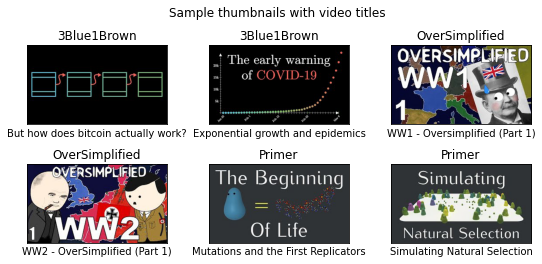

In [689]:
ipr = 3
fig, axs = plt.subplots(len(titles1) // ipr, ipr, figsize=(8, 4))
i = 0
for idx, row in s1.iterrows():
    img_path = os.path.join(img_dir, "{}.jpg".format(row["id_video"]))
    img = load_img(img_path)
    axs[i // ipr, i % ipr].imshow(img)
    axs[i // ipr, i % ipr].xaxis.set_ticklabels([])
    axs[i // ipr, i % ipr].xaxis.set_ticks([])
    axs[i // ipr, i % ipr].set_xlabel(row["title"])
    axs[i // ipr, i % ipr].set_title(row["channel_name"])
    axs[i // ipr, i % ipr].yaxis.set_ticklabels([])
    axs[i // ipr, i % ipr].yaxis.set_ticks([])
    # if i % 2 == 0:
    #     axs[i // 2, i % 2].set_ylabel(row["channel_name"])
    i += 1
plt.suptitle("Sample thumbnails with video titles", x=0.56)
# plt.tight_layout(pad=3)
plt.subplots_adjust(left=None, bottom=None, right=1.0, top=None, wspace=0.3, hspace=None)
plt.savefig(os.path.join(p_dir, "Channel sample images with titles.jpg"))
plt.show()

In [690]:
res = pd.concat([x_test.reset_index(), y_test.reset_index(), y_pred.reset_index()], axis=1)
res.drop(columns=["index"], inplace=True)
res.rename(columns={0: "pred"}, inplace=True)
res["qtl"] = res["qtl"].astype(object)
res.head()

,id_video,title,channel_id,channel_name,published_video,like_count,dislike_count,view_count_video,published_mth,title_len,id_channel,view_count_channel,published_channel,age_mth,subscriber_count,video_count,ln_vc_norm,qtl,pred
0,sD0NjbwqlYw,Visualizing the Riemann zeta function and anal...,UCYO_jab_esuFRV4b17AJtAw,3Blue1Brown,2016-12-09 17:50:56+00:00,66845.0,864.0,3196433.0,60,63,UCYO_jab_esuFRV4b17AJtAw,215018880,2015-03-03 23:11:55+00:00,81,3910000.0,115,-0.201502,very high,very high
1,AHz74SD0Nc0,Why Human Evolution Matters: Crash Course Big ...,UCX6b17PVsYBQ0ip5gyeme-Q,CrashCourse,2017-06-21 14:00:01+00:00,4478.0,175.0,198857.0,54,57,UCX6b17PVsYBQ0ip5gyeme-Q,1546387741,2006-05-20 02:43:42+00:00,187,12700000.0,1334,-4.156771,very low,very low
2,_Ii0d5yEdU0,Alice and Bob Meet the Wall of Fire - Order now!,UCTpmmkp1E4nmZqWPS-dl5bg,Quanta Magazine,2018-12-21 17:18:05+00:00,35.0,0.0,2159.0,36,48,UCTpmmkp1E4nmZqWPS-dl5bg,13206600,2015-06-08 20:54:50+00:00,78,333000.0,163,-5.038497,very low,very high
3,iu_HBmmjvUw,The Mitosis Song #shorts,UCC552Sd-3nyi_tk2BudLUzA,AsapSCIENCE,2021-07-19 16:00:31+00:00,6434.0,383.0,104911.0,5,24,UCC552Sd-3nyi_tk2BudLUzA,1538029538,2012-05-28 17:33:43+00:00,115,9740000.0,374,-4.530884,very low,very low
4,N7d_RWyOv20,How to Make a SQUARE Vortex Ring! ft. 3blue1brown,UC7DdEm33SyaTDtWYGO2CwdA,Physics Girl,2018-11-07 20:20:23+00:00,25941.0,297.0,700257.0,37,49,UC7DdEm33SyaTDtWYGO2CwdA,148707406,2011-10-21 15:36:08+00:00,122,2050000.0,183,-1.074148,very high,very high


In [691]:
# res.loc[(res["pred"] == res["qtl"]) & ("title" == "This is why we can't have nice things"), :].sort_values("ln_vc_norm", ascending=False).iloc[:10,:]
res.loc[(res["pred"] == res["qtl"]), :].sort_values("ln_vc_norm", ascending=False).iloc[60:70,:]

,id_video,title,channel_id,channel_name,published_video,like_count,dislike_count,view_count_video,published_mth,title_len,id_channel,view_count_channel,published_channel,age_mth,subscriber_count,video_count,ln_vc_norm,qtl,pred
425,Bine_PbyFSQ,Transistors - Field Effect and Bipolar Transis...,UCJ0yBou72Lz9fqeMXh9mkog,Physics Videos by Eugene Khutoryansky,2017-10-08 12:16:16+00:00,18637.0,474.0,1210440.0,50,69,UCJ0yBou72Lz9fqeMXh9mkog,59061719,2011-09-06 00:49:17+00:00,123,853000.0,120,0.349980,very high,very high
440,ZPpvS9wDOcA,Amazing Effects of Sleep (And Lack of it),UCt_t6FwNsqr3WWoL6dFqG9w,BrainCraft,2014-05-02 15:30:01+00:00,4932.0,305.0,822904.0,91,41,UCt_t6FwNsqr3WWoL6dFqG9w,35706035,2013-08-27 06:55:26+00:00,100,584000.0,234,0.342939,very high,very high
771,Xc4xYacTu-E,Which Way Is Down?,UC6nSFpj9HTCZ5t-N3Rm3-HA,Vsauce,2017-11-02 09:30:54+00:00,562592.0,10928.0,23917327.0,49,18,UC6nSFpj9HTCZ5t-N3Rm3-HA,2141610094,2007-07-30 20:43:33+00:00,173,17100000.0,382,0.335525,very high,very high
400,B4XzLDM3Py8,LIGO Detects Gravitational Waves,UCFe-pfe0a9bDvWy74Jd7vFg,Massachusetts Institute of Technology (MIT),2016-02-11 15:33:27+00:00,12243.0,293.0,1007480.0,70,32,UCFe-pfe0a9bDvWy74Jd7vFg,88512314,2009-01-14 16:58:54+00:00,155,724000.0,592,0.330416,very high,very high
814,xRel1JKOEbI,The Neuroscience of Consciousness – with Anil ...,UCYeF244yNGuFefuFKqxIAXw,The Royal Institution,2017-02-01 12:54:33+00:00,19180.0,1075.0,1475768.0,58,50,UCYeF244yNGuFefuFKqxIAXw,128175239,2009-09-16 11:05:59+00:00,147,1070000.0,934,0.321520,very high,very high
796,Wxj0_pfzXRs,Do You Know This Voice?,UCt_t6FwNsqr3WWoL6dFqG9w,BrainCraft,2015-09-24 17:30:00+00:00,11187.0,430.0,800536.0,75,23,UCt_t6FwNsqr3WWoL6dFqG9w,35706035,2013-08-27 06:55:26+00:00,100,584000.0,234,0.315381,very high,very high
531,MXJ-zpJeY3E,The World's Best Mathematician (*) - Numberphile,UCoxcjq-8xIDTYp3uz647V5A,Numberphile,2017-03-14 14:39:22+00:00,88232.0,1494.0,5313101.0,57,48,UCoxcjq-8xIDTYp3uz647V5A,589894242,2011-09-15 12:45:01+00:00,123,3890000.0,614,0.311766,very high,very high
1030,UjtOGPJ0URM,Why Alien Life Would be our Doom - The Great F...,UCsXVk37bltHxD1rDPwtNM8Q,Kurzgesagt – In a Nutshell,2018-02-01 13:00:05+00:00,541295.0,18369.0,21779207.0,46,51,UCsXVk37bltHxD1rDPwtNM8Q,1566316247,2013-07-09 20:17:20+00:00,101,16100000.0,145,0.302136,very high,very high
761,84aWtseb2-4,Daylight Saving Time Explained,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2011-10-24 12:00:00+00:00,83514.0,1363.0,6642182.0,122,30,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,0.276034,very high,very high
719,c8-J2c4U4-0,Relativistic Effects,UClq42foiSgl7sSpLupnugGA,D!NG,2018-03-09 19:03:38+00:00,66178.0,976.0,2402681.0,45,20,UClq42foiSgl7sSpLupnugGA,176352780,2015-09-02 15:46:33+00:00,75,1830000.0,255,0.272269,very high,very high


In [692]:
titles2 = [
    "A LIVING ROCK? -- Mind Blow #69",
    "Does this look white to you?",
    "Football War - MiniWars #2",
    "What Will We Miss?",
    "The True Science of Parallel Universes",
    "Childbirth vs Getting Kicked in the Balls"
]
s2 = res.loc[res["title"].isin(titles2), ["id_video", "title", "channel_name", "ln_vc_norm"]].sort_values(["channel_name", "title"])

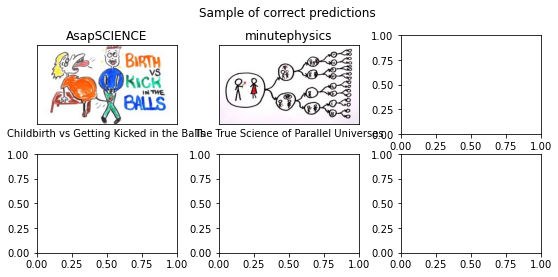

In [693]:
ipr = 3
fig, axs = plt.subplots(len(titles2) // ipr, ipr, figsize=(8, 4))
i = 0
for idx, row in s2.iterrows():
    img_path = os.path.join(img_dir, "{}.jpg".format(row["id_video"]))
    img = load_img(img_path)
    axs[i // ipr, i % ipr].imshow(img)
    axs[i // ipr, i % ipr].xaxis.set_ticklabels([])
    axs[i // ipr, i % ipr].xaxis.set_ticks([])
    axs[i // ipr, i % ipr].set_xlabel(row["title"])
    axs[i // ipr, i % ipr].set_title(row["channel_name"])
    axs[i // ipr, i % ipr].yaxis.set_ticklabels([])
    axs[i // ipr, i % ipr].yaxis.set_ticks([])
    # if i % 2 == 0:
    #     axs[i // 2, i % 2].set_ylabel(row["channel_name"])
    i += 1
plt.suptitle("Sample of correct predictions", x=0.56)
# plt.tight_layout(pad=3)
plt.subplots_adjust(left=None, bottom=None, right=1.0, top=None, wspace=0.3, hspace=None)
plt.savefig(os.path.join(p_dir, "Sample of correct predictions.jpg"))
plt.show()

In [694]:
# res.loc[(res["pred"] == res["qtl"]) & ("title" == "This is why we can't have nice things"), :].sort_values("ln_vc_norm", ascending=False).iloc[:10,:]
res.loc[(res["pred"] != res["qtl"]), :].sort_values("ln_vc_norm", ascending=True).iloc[80:90,:]

,id_video,title,channel_id,channel_name,published_video,like_count,dislike_count,view_count_video,published_mth,title_len,id_channel,view_count_channel,published_channel,age_mth,subscriber_count,video_count,ln_vc_norm,qtl,pred


In [695]:
titles3 = [
    "Derek Muller - The Element of Truth",
    "Cracking the Puzzle of Biodiversity",
    "StarTalk Snippet: Google Says What?",
    "Ask Joe Stuff #3",
    "Announcing the Crash Course Coins",
    "David Moore: Tabletop Physics"
]
s3 = res.loc[res["title"].isin(titles3), ["id_video", "title", "channel_name", "ln_vc_norm"]].sort_values(["channel_name"])

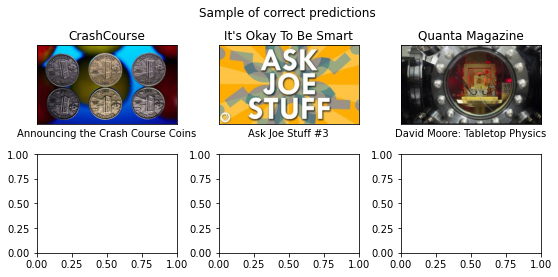

In [696]:
ipr = 3
fig, axs = plt.subplots(len(titles3) // ipr, ipr, figsize=(8, 4))
i = 0
for idx, row in s3.iterrows():
    img_path = os.path.join(img_dir, "{}.jpg".format(row["id_video"]))
    img = load_img(img_path)
    axs[i // ipr, i % ipr].imshow(img)
    axs[i // ipr, i % ipr].xaxis.set_ticklabels([])
    axs[i // ipr, i % ipr].xaxis.set_ticks([])
    axs[i // ipr, i % ipr].set_xlabel(row["title"])
    axs[i // ipr, i % ipr].set_title(row["channel_name"])
    axs[i // ipr, i % ipr].yaxis.set_ticklabels([])
    axs[i // ipr, i % ipr].yaxis.set_ticks([])
    # if i % 2 == 0:
    #     axs[i // 2, i % 2].set_ylabel(row["channel_name"])
    i += 1
plt.suptitle("Sample of correct predictions", x=0.56)
# plt.tight_layout(pad=3)
plt.subplots_adjust(left=None, bottom=None, right=1.0, top=None, wspace=0.3, hspace=None)
plt.savefig(os.path.join(p_dir, "Sample of incorrect predictions.jpg"))
plt.show()

In [697]:
titles4 = [
    "Does this look white to you?",
    "Announcing the Crash Course Coins"
]
s4 = res.loc[res["title"].isin(titles4), ["id_video", "title", "channel_name", "ln_vc_norm"]].sort_values(["channel_name", "title"])

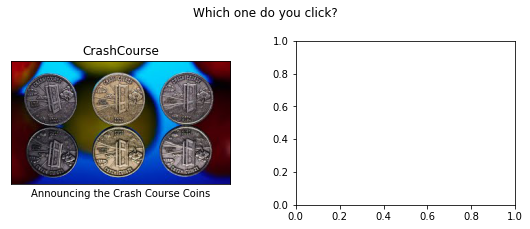

In [698]:
ipr = 2
fig, axs = plt.subplots(len(titles4) // ipr, ipr, figsize=(8, 4))
i = 0

# img_path = os.path.join(img_dir, "{}.jpg".format(row["id_video"][0]))
# img = load_img(img_path)
# axs[0, 0].imshow()

for idx, row in s4.iterrows():
    img_path = os.path.join(img_dir, "{}.jpg".format(row["id_video"]))
    img = load_img(img_path)
    axs[i % ipr].imshow(img)
    axs[i % ipr].xaxis.set_ticklabels([])
    axs[i % ipr].xaxis.set_ticks([])
    axs[i % ipr].set_xlabel(row["title"])
    axs[i % ipr].set_title(row["channel_name"])
    axs[i % ipr].yaxis.set_ticklabels([])
    axs[i % ipr].yaxis.set_ticks([])
    # if i % 2 == 0:
    #     axs[i // 2, i % 2].set_ylabel(row["channel_name"])
    i += 1
plt.suptitle("Which one do you click?", x=0.5, y=0.85)
plt.tight_layout(pad=3)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
plt.savefig(os.path.join(p_dir, "Which one do you click.jpg"))
plt.show()

# Stuff for Helmut

In [699]:
combo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5346 entries, 3100 to 16299
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   id_video            5346 non-null   object             
 1   title               5346 non-null   object             
 2   channel_id          5346 non-null   object             
 3   channel_name        5346 non-null   object             
 4   published_video     5346 non-null   datetime64[ns, UTC]
 5   like_count          5346 non-null   float64            
 6   dislike_count       5346 non-null   float64            
 7   view_count_video    5346 non-null   float64            
 8   published_mth       5346 non-null   int64              
 9   title_len           5346 non-null   int64              
 10  id_channel          5346 non-null   object             
 11  view_count_channel  5346 non-null   int64              
 12  published_channel   5346 non-n

In [700]:
channel = combo.groupby(["channel_name", "qtl"]).agg({"id_video": "count"})

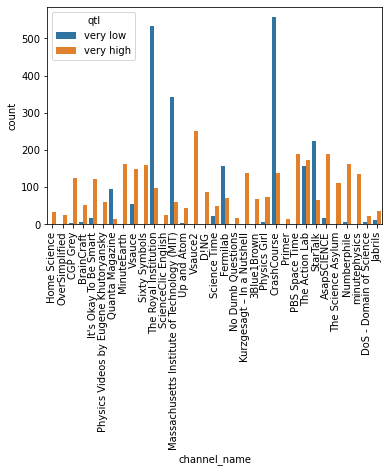

In [701]:
sb.countplot(x="channel_name", hue="qtl", data=combo)
plt.xticks(rotation=90)
plt.savefig(os.path.join(p_dir, "Channel_groundTruth_distribution.jpg"))
plt.show()

In [702]:
tot = pd.concat([combo], axis=0)
tot.shape

(5346, 18)

In [703]:
tot_gen = test_generator(tot.loc[:, [c for c in tot.columns if c != "qtl"]], tot["qtl"], img_dir, cat_lbl)
y_tot_prob = model.predict(tot_gen, steps=tot["qtl"].shape[0])
y_pred = np.argmax(y_tot_prob, axis=1)
y_pred = pd.Series([cat_lbl[i] for i in y_pred]).astype("category").cat.reorder_categories(cat_lbl)
tot = pd.concat([tot.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1)                        

In [704]:
# tot = pd.concat([train, val, test], axis=0)
tot.rename(columns={0: "pred"}, inplace=True)
tot.shape

(5346, 19)

In [705]:
tot["gt"] = (tot["qtl"] == "very high").astype(int)
tot["pred"] = (tot["pred"] == "very high").astype(int)
g = tot.groupby(["channel_name"]).agg({"id_video": "count", "pred": "sum", "gt": "sum"}).reset_index()
g.rename(columns={"id_video": "video_cnt", "pred": "pred_cnt", "gt": "gt_cnt"}, inplace=True)
g["gt_ratio"] = g["gt_cnt"] / g["video_cnt"]
g["pred_ratio"] = g["pred_cnt"] / g["video_cnt"]

In [706]:
tot.head()

,id_video,title,channel_id,channel_name,published_video,like_count,dislike_count,view_count_video,published_mth,title_len,id_channel,view_count_channel,published_channel,age_mth,subscriber_count,video_count,ln_vc_norm,qtl,pred,gt
0,XRFrXNJCviQ,22 Amazing Science Experiments! Compilation,UCJnlW_BAdjOYRcsQ0BsxZ1Q,Home Science,2021-05-19 09:41:59+00:00,51941.0,1880.0,6278848.0,7,43,UCJnlW_BAdjOYRcsQ0BsxZ1Q,198657265,2009-04-20 09:56:51+00:00,152,1140000.0,39,1.706158,very high,1,1
1,ROnxjj5jPDs,How to Make Amazing Tensegrity Structure - Ant...,UCJnlW_BAdjOYRcsQ0BsxZ1Q,Home Science,2020-06-14 12:38:33+00:00,23449.0,622.0,1604613.0,18,65,UCJnlW_BAdjOYRcsQ0BsxZ1Q,198657265,2009-04-20 09:56:51+00:00,152,1140000.0,39,0.341854,very high,1,1
2,uQHFQoFoxvQ,Experiment: Coca Cola and Drain Cleaner,UCJnlW_BAdjOYRcsQ0BsxZ1Q,Home Science,2019-05-23 18:56:42+00:00,13544.0,880.0,2679122.0,31,39,UCJnlW_BAdjOYRcsQ0BsxZ1Q,198657265,2009-04-20 09:56:51+00:00,152,1140000.0,39,0.854461,very high,1,1
3,M07JRzkgaR8,17 Amazing Experiments and Tricks! Compilation,UCJnlW_BAdjOYRcsQ0BsxZ1Q,Home Science,2018-07-04 10:35:14+00:00,121624.0,6875.0,13217618.0,41,46,UCJnlW_BAdjOYRcsQ0BsxZ1Q,198657265,2009-04-20 09:56:51+00:00,152,1140000.0,39,2.450522,very high,1,1
4,IZ4QqtXAM7A,How to Make a Huge Microscope Projector from a...,UCJnlW_BAdjOYRcsQ0BsxZ1Q,Home Science,2018-04-07 08:55:32+00:00,2679.0,225.0,342351.0,44,96,UCJnlW_BAdjOYRcsQ0BsxZ1Q,198657265,2009-04-20 09:56:51+00:00,152,1140000.0,39,-1.202947,very high,1,1


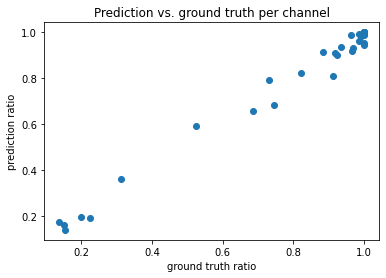

In [707]:
# plt.scatter(g.loc[(g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8), "cb_ratio"], g.loc[(g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8), "vh_ratio"], c="red")
# plt.scatter(g.loc[~((g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8)), "cb_ratio"], g.loc[~((g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8)), "vh_ratio"], c="blue")
plt.scatter(g["gt_ratio"], g["pred_ratio"])
plt.xlabel("ground truth ratio")
plt.ylabel("prediction ratio")
plt.title("Prediction vs. ground truth per channel")
plt.savefig(os.path.join(p_dir, "ground truth vs prediction_channel.jpg"))
plt.show()

In [708]:
tot2 = pd.concat([combo, combo2], axis=0)
tot2.shape

(9819, 18)

In [709]:
tot2.loc[tot2["qtl"] == "high", "qtl"] = "very high"
tot2.loc[tot2["qtl"] == "low", "qtl"] = "very low"
tot2_gen = test_generator(tot2.loc[:, [c for c in tot2.columns if c != "qtl"]], tot2["qtl"], img_dir, cat_lbl)
y_tot2_prob = model.predict(tot2_gen, steps=tot2["qtl"].shape[0])
y_pred2 = np.argmax(y_tot2_prob, axis=1)
y_pred2 = pd.Series([cat_lbl[i] for i in y_pred2]).astype("category").cat.reorder_categories(cat_lbl)
tot2 = pd.concat([tot2.reset_index(drop=True), y_pred2.reset_index(drop=True)], axis=1)                        

In [710]:
# tot = pd.concat([train, val, test], axis=0)
tot2.rename(columns={0: "pred"}, inplace=True)
tot2.shape

(9819, 19)

In [711]:
tot2["gt"] = (tot2["qtl"] == "very high").astype(int)
tot2["pred"] = (tot2["pred"] == "very high").astype(int)
g2 = tot2.groupby(["channel_name"]).agg({"id_video": "count", "pred": "sum", "gt": "sum"}).reset_index()
g2.rename(columns={"id_video": "video_cnt", "pred": "pred_cnt", "gt": "gt_cnt"}, inplace=True)
g2["gt_ratio"] = g2["gt_cnt"] / g2["video_cnt"]
g2["pred_ratio"] = g2["pred_cnt"] / g2["video_cnt"]

In [712]:
tot2.head()

,id_video,title,channel_id,channel_name,published_video,like_count,dislike_count,view_count_video,published_mth,title_len,id_channel,view_count_channel,published_channel,age_mth,subscriber_count,video_count,ln_vc_norm,qtl,pred,gt
0,XRFrXNJCviQ,22 Amazing Science Experiments! Compilation,UCJnlW_BAdjOYRcsQ0BsxZ1Q,Home Science,2021-05-19 09:41:59+00:00,51941.0,1880.0,6278848.0,7,43,UCJnlW_BAdjOYRcsQ0BsxZ1Q,198657265,2009-04-20 09:56:51+00:00,152,1140000.0,39,1.706158,very high,1,1
1,ROnxjj5jPDs,How to Make Amazing Tensegrity Structure - Ant...,UCJnlW_BAdjOYRcsQ0BsxZ1Q,Home Science,2020-06-14 12:38:33+00:00,23449.0,622.0,1604613.0,18,65,UCJnlW_BAdjOYRcsQ0BsxZ1Q,198657265,2009-04-20 09:56:51+00:00,152,1140000.0,39,0.341854,very high,1,1
2,uQHFQoFoxvQ,Experiment: Coca Cola and Drain Cleaner,UCJnlW_BAdjOYRcsQ0BsxZ1Q,Home Science,2019-05-23 18:56:42+00:00,13544.0,880.0,2679122.0,31,39,UCJnlW_BAdjOYRcsQ0BsxZ1Q,198657265,2009-04-20 09:56:51+00:00,152,1140000.0,39,0.854461,very high,1,1
3,M07JRzkgaR8,17 Amazing Experiments and Tricks! Compilation,UCJnlW_BAdjOYRcsQ0BsxZ1Q,Home Science,2018-07-04 10:35:14+00:00,121624.0,6875.0,13217618.0,41,46,UCJnlW_BAdjOYRcsQ0BsxZ1Q,198657265,2009-04-20 09:56:51+00:00,152,1140000.0,39,2.450522,very high,1,1
4,IZ4QqtXAM7A,How to Make a Huge Microscope Projector from a...,UCJnlW_BAdjOYRcsQ0BsxZ1Q,Home Science,2018-04-07 08:55:32+00:00,2679.0,225.0,342351.0,44,96,UCJnlW_BAdjOYRcsQ0BsxZ1Q,198657265,2009-04-20 09:56:51+00:00,152,1140000.0,39,-1.202947,very high,1,1


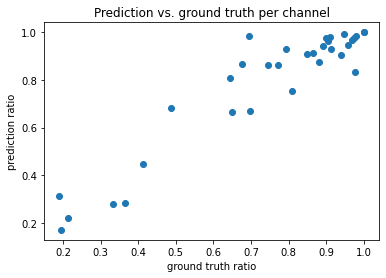

In [713]:
# plt.scatter(g.loc[(g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8), "cb_ratio"], g.loc[(g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8), "vh_ratio"], c="red")
# plt.scatter(g.loc[~((g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8)), "cb_ratio"], g.loc[~((g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8)), "vh_ratio"], c="blue")
plt.scatter(g2["gt_ratio"], g2["pred_ratio"])
plt.xlabel("ground truth ratio")
plt.ylabel("prediction ratio")
plt.title("Prediction vs. ground truth per channel")
plt.savefig(os.path.join(p_dir, "ground truth vs prediction_channel_w_middle.jpg"))
plt.show()

# Test model on the out of sample channels

In [714]:
cat_lbl = ["very low", "very high"]
combo_excl1 = combo_excl.loc[combo_excl.qtl.isin(cat_lbl), :]
combo_excl2 = combo_excl.loc[~combo_excl.qtl.isin(cat_lbl), :]
combo_excl1.qtl = combo_excl1.qtl.cat.remove_unused_categories()

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [715]:
combo_excl1.head()

,id_video,title,channel_id,channel_name,published_video,like_count,dislike_count,view_count_video,published_mth,title_len,id_channel,view_count_channel,published_channel,age_mth,subscriber_count,video_count,ln_vc_norm,qtl
2,toVfvRhWbj8,How Does A Carburetor Work? | Transparent Carb...,UC6107grRI4m0o2-emgoDnAA,SmarterEveryDay,2021-06-30 16:01:11+00:00,308158.0,2265.0,6157911.0,6,98,UC6107grRI4m0o2-emgoDnAA,974567798,2006-04-04 04:12:24+00:00,188,9980000.0,344,-0.482845,very high
3,TCxoZlFqzwA,How Does Film ACTUALLY Work? (It's MAGIC) [Ph...,UC6107grRI4m0o2-emgoDnAA,SmarterEveryDay,2021-06-13 21:14:30+00:00,108396.0,1653.0,2494470.0,6,91,UC6107grRI4m0o2-emgoDnAA,974567798,2006-04-04 04:12:24+00:00,188,9980000.0,344,-1.386507,very high
4,MUaTOoVmg1Q,"Exploding Weed Seeds (28,546 fps Slow Motion)-...",UC6107grRI4m0o2-emgoDnAA,SmarterEveryDay,2021-05-30 14:00:14+00:00,132375.0,2270.0,2478806.0,7,68,UC6107grRI4m0o2-emgoDnAA,974567798,2006-04-04 04:12:24+00:00,188,9980000.0,344,-1.392806,very high
6,flmkQZvN_g8,What happens when 2 Weedeaters Hit Each Other?...,UC6107grRI4m0o2-emgoDnAA,SmarterEveryDay,2021-04-30 01:02:05+00:00,126450.0,2480.0,2911797.0,8,96,UC6107grRI4m0o2-emgoDnAA,974567798,2006-04-04 04:12:24+00:00,188,9980000.0,344,-1.231813,very high
10,g3Ud6mHdhlQ,How Do Nuclear Submarines Make Oxygen?- Smarte...,UC6107grRI4m0o2-emgoDnAA,SmarterEveryDay,2021-02-21 14:00:10+00:00,178969.0,2349.0,5016298.0,10,61,UC6107grRI4m0o2-emgoDnAA,974567798,2006-04-04 04:12:24+00:00,188,9980000.0,344,-0.687891,very high


In [716]:
img_dir = "../images_medium"

test_gen = test_generator(combo_excl1.loc[:, [c for c in combo_excl1.columns if c != "qtl"]], combo_excl1["qtl"], img_dir, cat_lbl)
y_oos_prob = model.predict(test_gen, steps=combo_excl1["qtl"].shape[0])
y_pred = np.argmax(y_oos_prob, axis=1)
y_pred = pd.Series([cat_lbl[i] for i in y_pred]).astype("category").cat.reorder_categories(cat_lbl)

In [717]:
lb = mybinarizer()
y_test_no = lb.transform(combo_excl1["qtl"], cat_lbl)[:, 1]
y_pred_no = y_oos_prob[:,  1]
fpr, tpr, thr = roc_curve(y_test_no, y_pred_no)

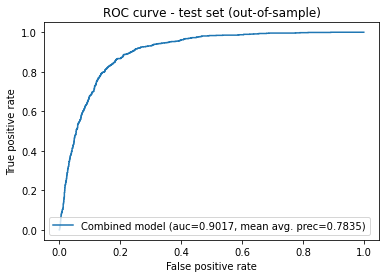

In [718]:
auc_model = auc(fpr, tpr)
mavgp = average_precision_score(y_test_no, y_pred_no)

plt.plot(fpr, tpr, label="Combined model (auc={:0.4f}, mean avg. prec={:0.4f})".format(auc_model, mavgp))
df_roc = pd.DataFrame({"fpr": fpr, "tpr": tpr})
df_roc.to_pickle("../roc_combo_v{}.pkl".format(version))
d_roc = pd.DataFrame({"auc": [auc_model], "mavgp": [mavgp]})
d_roc.to_pickle("../d_combo_v{}.pkl".format(version))

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve - test set (out-of-sample)")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve.jpg"))
plt.show()

In [721]:
l = list()
for i in range(8):
    l.append((pd.read_pickle("../roc_combo_v{}.pkl".format(i)), pd.read_pickle("../d_combo_v{}.pkl".format(i))))

li = list()
for i in range(8):
    li.append((pd.read_pickle("../roc_combo_is_v{}.pkl".format(i)), pd.read_pickle("../d_combo_is_v{}.pkl".format(i))))

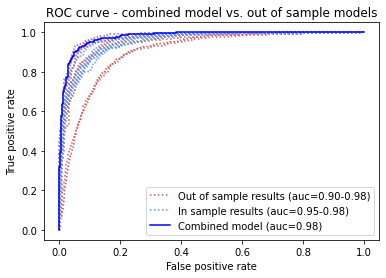

In [732]:
reds = ["#FF2400", "#FA8072", "#FF4433", "#E30B5C", "#E35335", "#DC143C", "#811331", "#C41E3A"]

def legend_text(txt, ix=None, auc=None, mavgp=None):
    if not mavgp:
        return "{}_{} (auc={:0.4f})".format(txt, ix, auc)
    elif not ix:
        # return "Combined model (auc={:0.4f}, mean avg. prec={:0.4f})".format(auc, mavgp)
        return "{} (auc={:0.4f})".format(txt, auc)
    # return "Out of sample model_{} (auc={:0.4f}, mean avg. prec={:0.4f})".format(ix, auc, mavgp)

ix = 0
oos = [1, 0]
for i in l:
    # plt.plot(i[0]["fpr"], i[0]["tpr"], c="indianred", linestyle="dotted", label=legend_text("Out of sample", ix, i[1]["auc"][0]))
    plt.plot(i[0]["fpr"], i[0]["tpr"], c="indianred", linestyle="dotted")
    if i[1]["auc"][0] < oos[0]:
        oos[0] = i[1]["auc"][0]
    if i[1]["auc"][0] > oos[1]:
        oos[1] = i[1]["auc"][0]
    ix += 1
    
ix = 0
iss = [1, 0]
for i in li:
    # plt.plot(i[0]["fpr"], i[0]["tpr"], c="cornflowerblue", linestyle="dotted", label=legend_text("In sample", ix, i[1]["auc"][0]))
    plt.plot(i[0]["fpr"], i[0]["tpr"], c="cornflowerblue", linestyle="dotted")
    if i[1]["auc"][0] < iss[0]:
        iss[0] = i[1]["auc"][0]
    if i[1]["auc"][0] > iss[1]:
        iss[1] = i[1]["auc"][0]
    ix += 1
    
elements = [
    Line2D([0], [0], color="indianred", linestyle="dotted", label="Out of sample results (auc={:0.2f}-{:0.2f})".format(oos[0], oos[1])),
    Line2D([0], [0], color="cornflowerblue", linestyle="dotted", label="In sample results (auc={:0.2f}-{:0.2f})".format(iss[0], iss[1]))
]
    
df_roc = pd.read_pickle("../roc_combo.pkl")
d_roc = pd.read_pickle("../d_combo.pkl")
# plt.plot(df_roc["fpr"], df_roc["tpr"], "b-", label=legend_text("Combined model", None, d_roc["auc"][0], d_roc["mavgp"][0]))
plt.plot(df_roc["fpr"], df_roc["tpr"], "b-")

elements.append(Line2D([0], [0], color="blue", label="Combined model (auc={:0.2f})".format(d_roc["auc"][0])))

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve - combined model vs. out of sample models")
plt.legend(handles=elements)
plt.savefig(os.path.join(p_dir, "Out of sample testing_roc-curve.jpg"))
plt.show()